### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
from shipping_audit_data import *
%matplotlib inline

### Script Settings

In [2]:
write_pdf = 'no'
close_workbook = 'no'

In [3]:
report_dict = {}

# run this every monday
now = (dt.datetime.now() - pd.DateOffset(days = 1)).date()
now_pretty = str(dt.datetime.now().date())

# our shipping week runs monday to sunday
date_end = now_pretty
date_start = str((now - pd.DateOffset(weeks = 53, days = -1)).date()) # takes us back to the Monday of the 53rd previous week 

csv_path = '/Users/jarad/Fake Folder/Shipping/Recurring/Shipping Audit/CSVs/'

html_path = '/Users/jarad/Fake Folder/Shipping/Recurring/Shipping Audit/HTML'
html_title = 'Weekly Shipping Audit.html'

pdf_path = '/Users/jarad/Fake Folder/Shipping/Recurring/Shipping Audit/Docs/Weekly Reports/'

style_sheet_path = '/Users/jarad/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

image_path = '/Users/jarad/Fake Folder/Shipping/Recurring/Shipping Audit/Images/Weekly/'

### Chart Settings

In [4]:
ups_yellow = '#FCB900'
ups_brown = '#301504'

dhl_red = '#D2002E'
dhl_yellow = '#FFCC01'

usps_blue = '#333366'
usps_grey = '#F7F7F7'

### Get shipping audit data

In [5]:
main = get_shipping_audit_data(date_start, date_end)


== shipping audit data start ==


== shipping audit data end ==



### Get week ending
For this script, a week ends on Sunday

In [6]:
main['day name'] = main['date purchased'].dt.day_name()
main['week ending'] = np.where(main['day name'] == 'Sunday', main['date purchased'].dt.date.map(str), np.nan)
main['week ending'].fillna(method = 'bfill', inplace = True)

### Exclude missing orders

In [7]:
main_clean = main.drop(main[main['missing'] == 'yes'].index)
main_clean.reset_index(drop = True, inplace = True)

In [8]:
main_clean.drop(main_clean[main_clean['week ending'].isnull()].index, inplace = True)
main_clean.reset_index(drop = True, inplace = True)

main_clean['ddp charge'].fillna(0, inplace = True)

### Get most recent three weeks

In [9]:
all_weeks = sorted(list(set(main_clean['week ending'].dropna())))

week_ls = all_weeks[-3:]

print('data covers weeks ending\n{}'.format('\n'.join(week_ls)))

data covers weeks ending
2019-05-12
2019-05-19
2019-05-26


### View all shipping module codes counts

In [10]:
a = main_clean.groupby(['week ending','shipping module code'])[['orders id']].count().unstack().fillna(0)
a.columns = a.columns.droplevel(0)

fmt = ['n0'] * len(a.columns)
a.tail().format_(fmt)

,DHL,UPS,USPS,Employee/Other,Reseller Shipping,Sameday
week ending,,,,,,
2019-04-28,238,"2,772","1,885",3,13,1
2019-05-05,222,"2,618","1,739",1,12,4
2019-05-12,239,"2,460","1,867",4,17,2
2019-05-19,124,"2,204","1,683",1,13,0
2019-05-26,0,876,"1,691",1,17,1


### Shipping profit
Excludes Free Shipping (for orders over $200) and AdaBox (our subscription box service with free shipping)

In [11]:
ls = ['UPS','DHL','USPS']

a = main_clean[(main_clean['free shipping'] == 'no')
             & (main_clean['adabox'] == 'no')
             & (main_clean['shipping module code'].isin(ls))]

by_week = a.groupby(['week ending','shipping module code']).agg({'orders id':'count','shipping profit':'sum'})
by_week.rename(columns = {'orders id':'unique OID count'}, inplace = True)

by_week['shipping profit per order'] = by_week['shipping profit']/by_week['unique OID count']

# create an empty row for the shipping services which do not have any data

ls1 = sorted(list(set(by_week.index.get_level_values(0))))
ls2 = ['DHL','UPS','USPS'] * len(ls1)

ls3 = []
for l1 in ls1:
    for i in range(3):
        ls3.append(l1)
        
for_join = pd.DataFrame({'week ending':ls3, 'shipping module code':ls2}).set_index(['week ending','shipping module code'])        
by_week = for_join.join(by_week).fillna(0)

# get missing orders

m1 = main[main['missing'] == 'yes'].groupby(['week ending','shipping module code'])[['orders id']].count()
m2 = main.groupby(['week ending','shipping module code'])[['orders id']].count()
m3 = m1.div(m2).fillna(0)

m3 = m3[m3.index.get_level_values(1).isin(ls)].copy()

m3.rename(columns = {'orders id':'missing as a % of service'}, inplace = True)

# merge all

by_week = by_week.join(m3)

### Get most recent three weeks of data

In [12]:
by_week_recent = by_week[by_week.index.get_level_values(0).isin(week_ls)].copy()
by_week_recent.sort_index(level = 0, ascending = False, inplace = True)

fmt = ['n0','m0','m2','p0']
display(by_week_recent.format_(fmt))

report_dict['by week recent table'] = by_week_recent.format_(fmt).to_html(index = True)

a = by_week_recent['unique OID count'].sum()
b = by_week_recent['shipping profit'].sum()
c = b/a

by_week_recent_totals = 'Total OID count: {:,.0f}\nTotal shipping profit: ${:,.0f}\nAvg shipping profit per order: ${:,.2f}'.format(a,b,c)
print(by_week_recent_totals)

report_dict['by week recent totals'] = by_week_recent_totals.replace('\n','<br>')

Unique OID Count Shipping Profit  \
week ending shipping module code                                    
2019-05-26  USPS                            1,688          $3,346   
            UPS                               788            $268   
            DHL                                 0              $0   
2019-05-19  USPS                            1,677          $3,300   
            UPS                             1,897            $321   
            DHL                               124            $285   
2019-05-12  USPS                            1,861          $3,693   
            UPS                             2,096            $532   
            DHL                               239            $-89   

                                 Shipping Profit Per Order  \
week ending shipping module code                             
2019-05-26  USPS                                     $1.98   
            UPS                                      $0.34   
            DHL                                      $0.00   
2019-05-19  USPS                                     $1.97   
            UPS                                      $0.17   
            DHL                                      $2.30   
2019-05-12  USPS                                     $1.98   
            UPS                                      $0.25   
            DHL                                     $-0.37   

                                 Missing As A % Of Service  
week ending shipping module code                            
2019-05-26  USPS                                        0%  
            UPS                                        60%  
            DHL                                       100%  
2019-05-19  USPS                                        0%  
            UPS                                         5%  
            DHL                                        64%  
2019-05-12  USPS                                        0%  
            UPS                                         0%  
            DHL                                        37%

Total OID count: 10,370
Total shipping profit: $11,656
Avg shipping profit per order: $1.12


### DHL losses

In [13]:
excel_dict = {}

In [14]:
dhl_loss = main_clean[(main_clean['shipping module code'] == 'DHL')
                    & (main_clean['week ending'].isin(week_ls))
                    & (main_clean['profit loss'] == 'yes')
                    & (main_clean['adabox'] == 'no')
                    & (main_clean['free shipping'] == 'no')].copy()

In [15]:
# where DHL charged DDP, we did not, and our service charge was greater than DHL's
a = dhl_loss[(dhl_loss['ddp revenue'] == 0)
           & (dhl_loss['ddp charge'] > 0)
           & (dhl_loss['service revenue'] >= dhl_loss['service charge'])]

excel_dict['DHL No DDP'] = a

In [16]:
# where our DDP was not enough
b = dhl_loss[(dhl_loss['ddp revenue'] < dhl_loss['ddp charge'])
           & (dhl_loss['service revenue'] >= dhl_loss['service charge'])
           & (~dhl_loss['orders id'].isin(a['orders id']))]

excel_dict['DHL Not Enough DDP'] = b

In [17]:
# excluding DDP: where our service charge was not enough
c = dhl_loss[(dhl_loss['service revenue'] < dhl_loss['service charge'])
           & (~dhl_loss['orders id'].isin(b['orders id']))]

excel_dict['DHL Not Enough Service'] = c

In [18]:
if len(a) + len(b) + len(c) != len(dhl_loss):
    raise ValueError('your dhl_loss counts do not match')

In [19]:
ls1 = ['Adafruit did not charge DDP but DHL did',
      'DHL DDP greater than Adafruit DDP',
      'Excluding DDP: DHL service charge greater than Adafruit service charge']

ls2 = []
ls3 = []
for df in [a,b,c]:
    ls2.append(len(df))
    ls3.append(df['shipping profit'].sum())
    
cols = ['group','count','profit loss']
losses = pd.DataFrame(columns = cols, data = np.column_stack([ls1,ls2,ls3]))    

for col in losses.columns[-2:]:
    losses[col] = pd.to_numeric(losses[col])

losses.sort_values('count', ascending = False, inplace = True)    

t = pd.DataFrame({'group':'Three Week Total',
                  'count':np.sum(ls2),
                  'profit loss':np.sum(ls3)},
                  index = [0])

losses = pd.concat([losses,t], sort = False)
    
fmt = [0,'n0','m0']
display(losses.format_(fmt))

report_dict['dhl losses table'] = losses.format_(fmt).to_html(index = False)

,Group,Count,Profit Loss
2,Excluding DDP: DHL service charge greater than Adafruit service charge,86,$-638
1,DHL DDP greater than Adafruit DDP,22,$-258
0,Adafruit did not charge DDP but DHL did,2,$-9
0,Three Week Total,110,$-905


*****
# Excel
*****

### Set up workbook

In [20]:
excel_dict['All Data'] = main_clean[main_clean['week ending'].isin(week_ls)]

In [21]:
suffix = ''
workbook_title = 'w.e. ' + week_ls[-1] + ' - Weekly Shipping Audit Data'

workbook = xlsxwriter.Workbook(csv_path + workbook_title + '.xlsx',
                               {'nan_inf_to_errors': True,
                               'strings_to_numbers': True})

tabs = ['All Data',
       'DHL No DDP',
       'DHL Not Enough DDP',
       'DHL Not Enough Service']

#=========================
# Formats
#=========================

colors = ['#343635',
          '#2e4874',
          '#7eaba4',
          '#928c85',
          '#347c83',
          '#bfb9d6']
colors = colors * 2

title = workbook.add_format({'font_size':25,
                             'font_name':'Arial (Bold)'})

subtitle = workbook.add_format({'font_size':15,
                                 'font_name':'Arial (Bold)'})


col_names = workbook.add_format({'font_name':'Arial (Bold)',
                                 'font_color':'white',
                                 'valign':'vcenter',
                                 'align':'center',
                                 'bg_color':colors[2],
                                 'bottom':1,
                                 'top':1,
                                 'left':1,
                                 'right':1})

money = workbook.add_format({'num_format':'$#,##0'})
money2 = workbook.add_format({'num_format':'$#,##0.00'})
percent = workbook.add_format({'num_format':'0.0%'})
number = workbook.add_format({'num_format':'#,##0'})
date = workbook.add_format({'num_format':'yyyy-mm-dd'})
dummy = workbook.add_format({'font_color':'black'})

for tab in tabs:
    workbook.add_worksheet(tab) # create each tab

my_worksheets = {}
for sht in workbook.worksheets():
    my_worksheets[sht.get_name()] = sht # create dict like tab_name:worksheet_instance

#=========================
# Apply same formatting to each worksheet
#=========================

for k, v in my_worksheets.items():
    sht = my_worksheets[k]
    sht.write(0, 0,
              k.title(),
              title)
    sht.write(1, 0,
              workbook_title,
              subtitle)

### Worksheets

In [22]:
for k in excel_dict.keys():
    
    sht = my_worksheets[k]
    
    df = excel_dict[k].copy()
    df.replace([np.nan,np.inf], '', inplace = True)
    df['date purchased'] = df['date purchased'].dt.date.map(str)
    
    #=========================
    # create format dict
    #=========================
    ls1 = []
    for col in df.columns:
        if df[col].dtype == 'float64':
            ls1.append(col)
            
    fmt = dict(zip(ls1, [money2] * len(ls1)))

    for c in ['date purchased','week ending']:
        fmt[c] = date
        
    #=========================        
    # write worksheets
    #=========================
    
    start_row = 3
    start_col = 0
    
    sht.write(start_row, start_col, k.title(), subtitle)
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)
        
        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.columns[i]] if df.columns[i] in ls1 else dummy)

if close_workbook == 'yes':
    workbook.close()

### Avg weeky UPS and DHL profit

In [23]:
a = main_clean[(main_clean['free shipping'] == 'no')
             & (main_clean['adabox'] == 'no')
             & (main_clean['shipping module code'].isin(['UPS','DHL']))]
n = 12 # most recent 12 weeks
b = a.groupby('week ending')[['shipping profit']].sum().tail(n)

In [24]:
# a function i wrote to get confidence intervals
c = jb_conf(b).loc[:'upper'].reset_index()
c.rename(columns = {'index':'Most Recent {} Weeks'.format(n)}, inplace = True)

fmt = [0,'m0']
display(c.format_(fmt))

report_dict['confidence interval table'] = c.format_(fmt).to_html(index = False)

,Most Recent 12 Weeks,Shipping Profit
0,lower,$977
1,mean,"$1,496"
2,upper,"$2,014"


### Charts

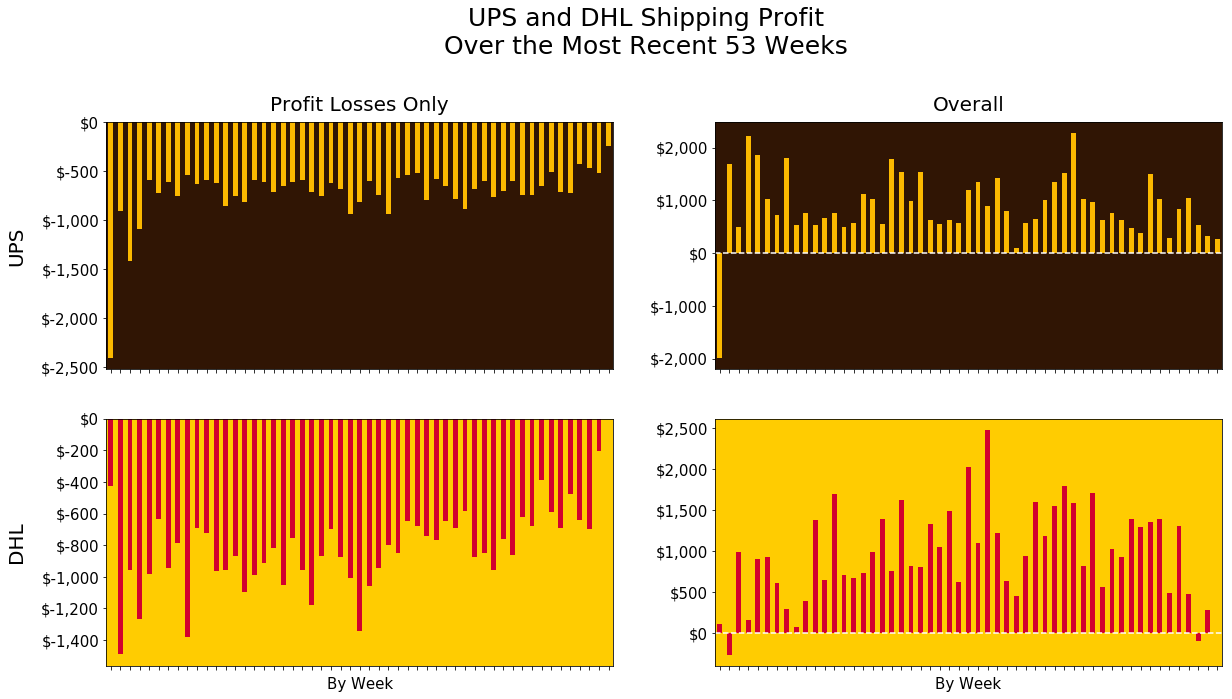

In [25]:
n = 2
c = 2
fig, axes  = plt.subplots(figsize = (20,10), nrows = n, ncols = c)

ls1 = ['UPS','DHL']
ls2 = [['yes'],['yes','no']]
ls3 = [[ups_yellow,ups_brown],[dhl_red,dhl_yellow]]

for i in range(len(ls1)):
    for j in range(len(ls2)):
        
        s = ls1[i]
        p = ls2[j]
        
        a = main_clean[(main_clean['shipping module code'] == s)
                     & (main_clean['profit loss'].isin(p))
                     & (main_clean['adabox'] == 'no')
                     & (main_clean['free shipping'] == 'no')]
        
        n = 53
        b = a.groupby('week ending')[['shipping profit']].sum().tail(n)
        
        d = pd.DataFrame({'week ending':all_weeks})
        d.set_index('week ending', inplace = True)        
        
        b = d.join(b)
        b.fillna(0, inplace = True)
        
        b.plot(ax = axes[i,j],
              kind = 'bar',
              color = ls3[i][0])
        
        axes[i,j].set_facecolor(ls3[i][1])
        axes[i,j].set_yticklabels(['${:,.0f}'.format(x) for x in axes[i,j].get_yticks()], fontsize = 15)
        axes[i,j].legend().set_visible(False)
        axes[i,j].set_xticklabels('')
        axes[i,j].set_xlabel('')        
        
for i in range(2):
    axes[i,0].set_ylabel(ls1[i], fontsize = 20, labelpad = 15)
    axes[i,1].axhline(0,ls = '--', color = 'white')
    axes[1,i].set_xlabel('By Week', fontsize = 15)
    
axes[0,0].set_title('Profit Losses Only', fontsize = 20, y = 1.02)
axes[0,1].set_title('Overall', fontsize = 20, y = 1.02)
    
plt.suptitle('UPS and DHL Shipping Profit\nOver the Most Recent {} Weeks'.format(n),
            y = 1.04,
            fontsize = 25)

plt.show()
fig.savefig(image_path + 'UPS and DHL Shipping Profit', bbox_inches = 'tight')

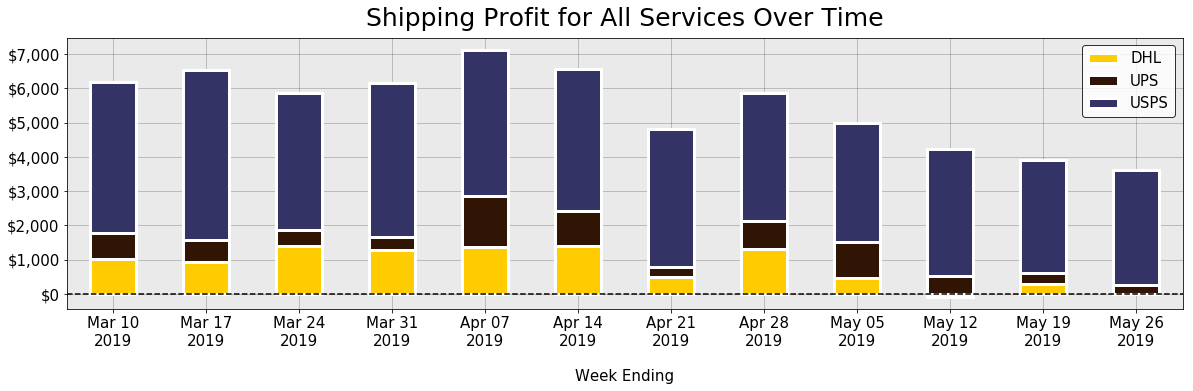

In [26]:
a = by_week[['shipping profit']].unstack(1)
a.columns = a.columns.droplevel(0)

n = 12
b = a.tail(n)

d = {'UPS':ups_brown,
    'DHL':dhl_yellow,
    'USPS':'#333366'}

color_ls = []
for col in b.columns.tolist():
    color_ls.append(d[col])

fig, ax = plt.subplots(figsize = (20,5))
b.plot(kind = 'bar',
      stacked = True,
      ax = ax,
      color = color_ls,
      edgecolor = 'white',
      lw = 3,
      zorder = 5)

ax.axhline(0, ls = '--', color = 'black', zorder = 10)
ax.set_facecolor('#eaeaea')
ax.grid(alpha = 0.25, color = 'black', zorder = 0)
ax.legend(frameon = True, edgecolor = 'black', fontsize = 15)
ax.set_title('Shipping Profit for All Services Over Time', fontsize = 25, y = 1.02)
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 15)
labs = jb_dates(pd.Series(b.index), 'date xticks')
ax.set_xticklabels(labs, rotation = 0, fontsize = 15)
ax.set_xlabel('Week Ending', fontsize = 15, labelpad = 20)

plt.show()
fig.savefig(image_path + ax.get_title(), bbox_inches = 'tight')

### HTML for PDF Report

In [27]:
print('this report covers weeks ending\n{}'.format('\n'.join(week_ls[-3:])))

this report covers weeks ending
2019-05-12
2019-05-19
2019-05-26


In [28]:
if write_pdf == 'yes':
    
    data_link = 'https://drive.google.com/open?id=1ooCg23KcDWVEEt_Vwb1H2-EQt0vr-ZfE'
    report_title = 'w.e. ' + week_ls[-1] + ' - Weekly Shipping Audit.pdf'        

    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'week_ending':week_ls[-1],
                    'now':now_pretty,
                    'data_link':data_link,
                    'by_week_recent_totals':report_dict['by week recent totals'],
                    'by_week_recent_table':report_dict['by week recent table'],
                    'dhl_losses_table':report_dict['dhl losses table'],
                    'confidence_interval_table':report_dict['confidence interval table']}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title,
                                      stylesheets = [style_sheet_path])                               

In [29]:
print('done')

done


### Explore

In [96]:
w = sorted(list(set(main_clean['week ending'])))[-10:]

df = main_clean[(main_clean['shipping module code'] == 'DHL')
              & (main_clean['profit loss'] == 'no')
              & (main_clean['adabox'] == 'no')
              & (main_clean['free shipping'] == 'no')
              & (main_clean['week ending'].isin(w))]

In [97]:
df.groupby('week ending')[['shipping profit']].quantile(np.arange(0,1.05,0.05)).unstack()

shipping profit                                                \
                       0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40  0.45   
week ending                                                                 
2019-03-24              0.0  0.0 -0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.00   
2019-03-31             -0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00   
2019-04-07              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00   
2019-04-14              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00   
2019-04-21              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00   
2019-04-28              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.75   
2019-05-05              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.00   
2019-05-12             -0.0  0.0  0.0  0.0  0.0 -0.0  0.0  0.0  0.0  0.00   
2019-05-19             -0.0 -0.0  0.0  0.0  0.0 -0.0 -0.0  0.0  0.0  0.00   

                                                                            
            0.50  0.55 0.60 0.65 0.70 0.75 0.80   0.85  0.90   0.95   1.00  
week ending                                                                 
2019-03-24   1.0  2.00  3.0  4.0  5.0  6.0  7.0   8.30  12.2  27.00  211.0  
2019-03-31   0.0  1.00  2.0  3.0  4.0  5.0  6.2   8.00  12.1  21.20  450.0  
2019-04-07   1.0  2.00  3.0  4.0  5.0  6.0  8.0  11.00  13.0  23.00  138.0  
2019-04-14   1.0  2.00  3.0  4.0  5.0  6.0  8.0  11.00  17.0  24.00  171.0  
2019-04-21   0.0  2.00  2.0  3.0  4.0  5.0  6.0   7.10  13.0  21.00   91.0  
2019-04-28   2.0  3.00  4.0  4.0  5.0  6.0  8.0  10.00  16.0  33.25  204.0  
2019-05-05   3.0  3.00  4.0  4.0  4.0  5.0  7.0  10.00  12.0  20.20  217.0  
2019-05-12   0.0  0.00  1.0  3.0  4.0  4.0  4.0   5.00   7.0  13.00   83.0  
2019-05-19   0.5  2.95  4.0  4.0  4.0  6.0  7.2   9.65  11.0  19.95   83.0

In [98]:
df.groupby('week ending')[['shipping profit']].count()

,shipping profit
week ending,
2019-03-24,299
2019-03-31,300
2019-04-07,305
2019-04-14,301
2019-04-21,267
2019-04-28,196
2019-05-05,159
2019-05-12,163
2019-05-19,90


In [82]:
df[df['week ending'] == '2019-05-12'].sort_values('shipping profit')

,date purchased,orders id,shipping module code,delivery city,delivery state,delivery country,customer,year and month,year and quarter,ddp revenue,service revenue,subtotal,shipping revenue,free shipping,service charge,ddp charge,shipping charge,shipping profit,profit loss,adabox,missing,day name,week ending
272984,2019-05-06,2050390,DHL,st johns park,new south wales,australia,non reseller,2019-05,2019-Q2,35.09,113.95,738.90,149.04,no,131.78,86.11,217.89,-69.0,yes,no,no,Monday,2019-05-12
272383,2019-05-06,2049755,DHL,bregenz,voralberg,austria,non reseller,2019-05,2019-Q2,294.36,61.61,1424.25,355.97,no,49.09,359.57,408.66,-53.0,yes,no,no,Monday,2019-05-12
275441,2019-05-10,2052977,DHL,bangkok,bangkok,thailand,non reseller,2019-05,2019-Q2,20.53,26.50,266.70,47.03,no,30.67,52.51,83.18,-36.0,yes,no,no,Friday,2019-05-12
273149,2019-05-07,2050562,DHL,roveleto di cadeo,piacenza,italy,non reseller,2019-05,2019-Q2,65.68,65.89,250.50,131.57,no,88.32,72.14,160.46,-29.0,yes,no,no,Tuesday,2019-05-12
274150,2019-05-08,2051614,DHL,tiel,ge,netherlands,non reseller,2019-05,2019-Q2,14.82,20.99,73.85,35.81,no,24.66,37.22,61.88,-26.0,yes,no,no,Wednesday,2019-05-12
274679,2019-05-09,2052170,DHL,chiang mai,chiang mai,thailand,non reseller,2019-05,2019-Q2,24.20,38.39,307.35,62.59,no,26.50,61.90,88.40,-26.0,yes,no,no,Thursday,2019-05-12
274689,2019-05-09,2052181,DHL,helsinki,helsinki,finland,non reseller,2019-05,2019-Q2,54.60,32.73,194.80,87.33,no,36.25,70.90,107.15,-20.0,yes,no,no,Thursday,2019-05-12
275493,2019-05-10,2053032,DHL,jade,nds,germany,non reseller,2019-05,2019-Q2,10.24,24.66,124.05,34.90,no,24.66,28.04,52.70,-18.0,yes,no,no,Friday,2019-05-12
275183,2019-05-09,2052707,DHL,domaslaw,dolnoslaskie,poland,non reseller,2019-05,2019-Q2,21.11,36.82,54.95,57.93,no,48.88,25.65,74.53,-17.0,yes,no,no,Thursday,2019-05-12
275681,2019-05-10,2053231,DHL,veghel,veghel,netherlands,non reseller,2019-05,2019-Q2,14.38,28.51,39.95,42.89,no,28.51,30.15,58.66,-16.0,yes,no,no,Friday,2019-05-12
